In [1]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = '/usr/lib/spark'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/

Using Python version 2.7.14 (default, Mar 12 2018 12:37:12)
SparkContext available as sc, HiveContext available as sqlContext.


In [2]:
# definee HDFS celju, kuraa Flume agjents ievieto tweetus
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
#tweetsFilePath = "hdfs://quickstart.cloudera:8020/tmp/tweets/data2/2018/04/03/17/FlumeData.1522766433913"
tweetsFilePath = "hdfs://quickstart.cloudera:8020/tmp/tweets/data2/"
#df = sqlContext.read.json(tweetsFilePath, multiLine=True)
df = sqlContext.read.json(tweetsFilePath)

In [3]:
# atlasa 5 tweetus testa noluukos
#df.createOrReplaceTempView("df")
df.select("created_at","text","lang").filter("lang = 'en'").show(5)

+--------------------+--------------------+----+
|          created_at|                text|lang|
+--------------------+--------------------+----+
|Tue Apr 03 15:45:...|How Big Data Is U...|  en|
|Tue Apr 03 15:45:...|We can’t wait to ...|  en|
|Tue Apr 03 15:45:...|The implementatio...|  en|
|Tue Apr 03 15:45:...|How does the data...|  en|
|Tue Apr 03 15:45:...|It's not about Bi...|  en|
+--------------------+--------------------+----+
only showing top 5 rows



In [4]:
# atlasa 5 JAUNAAKOS tweetus testam, lai saprastu vai HDFS direktorijaa jau ir redzami jaunaakie tweeti
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import to_date
#df2.unpersist()
# OK: #df2=df.select("created_at","text","lang").filter("lang = 'en'").sort('created_at', desc=True).show(5)
# df2=df.select("created_at","text","lang").sort('created_at', asc=True).show(1000)
# df2=df.sort(unix_timestamp(df("created_at"), "YYYY-MM-dd hh.mm.ss.S a").cast("timestamp"))
# OK: df2=df.sort(to_date("created_at"))
#df2=df.select("created_at","text","lang").filter("lang = 'en'").sort(to_date("created_at"), asc=False)

#df2=
df.select("created_at","text","lang").filter("lang = 'en'").sort('created_at', desc=True).show(5)
#df2.show(5)

#df2=df.select("created_at","text","lang").filter("lang = 'en'").sort('created_at', ascending=True).show(5)
#df2.takeOrdered(2, key=lambda x: -x[2])

+--------------------+--------------------+----+
|          created_at|                text|lang|
+--------------------+--------------------+----+
|Fri Apr 06 10:10:...|RT @FriendUPCloud...|  en|
|Fri Apr 06 10:10:...|RT @Iskratel: Fol...|  en|
|Fri Apr 06 10:10:...|Creating Value Fr...|  en|
|Fri Apr 06 10:10:...|RT @Shirleymelton...|  en|
|Fri Apr 06 10:10:...|Protecting Artifi...|  en|
+--------------------+--------------------+----+
only showing top 5 rows



In [5]:
# nodefinee pozitiivo tweetu sarakstu
pos_tweets = [('I love this analytical report', 'positive'),
              ('This Big data view is amazing', 'positive'),
              ('I feel great this morning as a data scientist', 'positive'),
              ('I am so excited about the business intelligence', 'positive'),
              ('It is my best mapreduce job', 'positive')]

In [6]:
# nodefinee negatiivo tweetu sarakstu
neg_tweets = [('I do not like this analytical report', 'negative'),
              ('This Bid data view is horrible', 'negative'),
              ('I feel tired this morning as a data scientist', 'negative'),
              ('I am not looking forward to the business intelligence', 'negative'),
              ('The mapreduce is my enemy', 'negative')]

In [7]:
# no abiem ieprieksheejiem sarakstiem izveido vienu sarakstu (tuple), kas satur abus elementus. 
# Pirmais ir vaardu masiivs, bet otrais ir par sentimentiem.
# Skatu tikai vaardus, kas garaaki par 2 rakstziimeem un visus konverteeju uz lowercase.
tweets = []
for (words, sentiment) in pos_tweets + neg_tweets:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    tweets.append((words_filtered, sentiment))
print tweets

[(['love', 'this', 'analytical', 'report'], 'positive'), (['this', 'big', 'data', 'view', 'amazing'], 'positive'), (['feel', 'great', 'this', 'morning', 'data', 'scientist'], 'positive'), (['excited', 'about', 'the', 'business', 'intelligence'], 'positive'), (['best', 'mapreduce', 'job'], 'positive'), (['not', 'like', 'this', 'analytical', 'report'], 'negative'), (['this', 'bid', 'data', 'view', 'horrible'], 'negative'), (['feel', 'tired', 'this', 'morning', 'data', 'scientist'], 'negative'), (['not', 'looking', 'forward', 'the', 'business', 'intelligence'], 'negative'), (['the', 'mapreduce', 'enemy'], 'negative')]


In [8]:
# nodefinee testa tweetu sarakstu
test_tweets = [
    (['feel', 'happy', 'this', 'morning'], 'positive'),
    (['analyse', 'great'], 'positive'),
    (['not', 'like', 'that', 'report'], 'negative'),
    (['analytical', 'report', 'not', 'great'], 'negative'),
    (['your', 'report', 'annoying'], 'negative')]

In [9]:
# Klasifikaacija
# Ar 2 funkciju paliidziibu no tweetiem izvelk vaardu ieziimes 
# (saraksts ar unikaaliem vaardiem, sakaartots peec biezhuma).
# Izmanto NLTK - Natural Language Toolkit (http://www.nltk.org/)
import nltk
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    print wordlist
    word_features = wordlist.keys()
    return word_features
word_features = get_word_features(get_words_in_tweets(tweets))
#word_list = get_word_features(get_words_in_tweets(wordlist))
#print word_list
print word_features

<FreqDist with 28 samples and 48 outcomes>
['love', 'tired', 'feel', 'intelligence', 'report', 'scientist', 'best', 'looking', 'amazing', 'horrible', 'forward', 'excited', 'business', 'big', 'bid', 'about', 'job', 'not', 'data', 'enemy', 'great', 'like', 'this', 'mapreduce', 'morning', 'analytical', 'the', 'view']


In [10]:
# Lai izveidotu klasifikatoru, ir nepieciesams noskaidrot, kuras iezimes ir butiskas, 
# tapec izvelk taas (extract_features).
# Izmanto vardnicu ar vaardiem, ko satur ievadiitais tweets (input).
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features
#    print features
#dict_features = extract_features(document)
#print extract_features(tweets)
print "Izpildam testu uz ['love', 'this', 'report']"
print extract_features(['love', 'this', 'report'])

Izpildam testu uz ['love', 'this', 'report']
{'contains(looking)': False, 'contains(not)': False, 'contains(excited)': False, 'contains(view)': False, 'contains(bid)': False, 'contains(data)': False, 'contains(business)': False, 'contains(intelligence)': False, 'contains(forward)': False, 'contains(love)': True, 'contains(horrible)': False, 'contains(the)': False, 'contains(great)': False, 'contains(enemy)': False, 'contains(feel)': False, 'contains(like)': False, 'contains(about)': False, 'contains(big)': False, 'contains(tired)': False, 'contains(morning)': False, 'contains(best)': False, 'contains(report)': True, 'contains(analytical)': False, 'contains(this)': True, 'contains(scientist)': False, 'contains(amazing)': False, 'contains(job)': False, 'contains(mapreduce)': False}


In [11]:
# Izmantojot ieprieksh nodefineeto 'feature extractor', vaardu ieziimes var izmantot klasifikatoraa, izman-
# tojot metodi apply_features un padodot ieziimju klasifikatoru saakumaa nodefineetam 'tweets' sarakstam.
training_set = nltk.classify.apply_features(extract_features, tweets)
# Mainiigais ‘training_set’ satur ieziimju kopu. Tas ir tuples veida saraksts, kur katra tuple satur 
# ieziimju vaardniicu un sentimenta veertiibu katram tweetam. Sentimenta veertiiba arii ir ‘label’.
print training_set

[({'contains(looking)': False, 'contains(not)': False, 'contains(excited)': False, 'contains(view)': False, 'contains(bid)': False, 'contains(data)': False, 'contains(business)': False, 'contains(intelligence)': False, 'contains(forward)': False, 'contains(love)': True, 'contains(horrible)': False, 'contains(the)': False, 'contains(great)': False, 'contains(enemy)': False, 'contains(feel)': False, 'contains(like)': False, 'contains(about)': False, 'contains(big)': False, 'contains(tired)': False, 'contains(morning)': False, 'contains(best)': False, 'contains(report)': True, 'contains(analytical)': True, 'contains(this)': True, 'contains(scientist)': False, 'contains(amazing)': False, 'contains(job)': False, 'contains(mapreduce)': False}, 'positive'), ({'contains(looking)': False, 'contains(not)': False, 'contains(excited)': False, 'contains(view)': True, 'contains(bid)': False, 'contains(data)': True, 'contains(business)': False, 'contains(intelligence)': False, 'contains(forward)': Fa

In [12]:
# Kad ir sagatavots training set, tad var apmaaciit klasifikatoru. Izmantojam NaiveBayes klasifikatoru.
classifier = nltk.NaiveBayesClassifier.train(training_set)
#print label_probdist.prob('positive') # = 50%
#print label_probdist.prob('negative') # = 50%

In [13]:
# izdrukaajam klasifikatora visvairaak informatiivaas ieziimes, 
# izmantojot metodi show_most_informative_features. No resultaata redzams, ka, 
# ja input tweets nesatur vaardu ‘not’, tad pozitivais koeficients ir 1.6.
print classifier.show_most_informative_features(10)

Most Informative Features
           contains(the) = True           negati : positi =      1.7 : 1.0
           contains(not) = False          positi : negati =      1.6 : 1.0
           contains(the) = False          positi : negati =      1.3 : 1.0
         contains(about) = False          negati : positi =      1.2 : 1.0
           contains(job) = False          negati : positi =      1.2 : 1.0
         contains(tired) = False          positi : negati =      1.2 : 1.0
       contains(excited) = False          negati : positi =      1.2 : 1.0
         contains(great) = False          negati : positi =      1.2 : 1.0
          contains(like) = False          positi : negati =      1.2 : 1.0
          contains(love) = False          negati : positi =      1.2 : 1.0
None


In [14]:
# Kad klasifikators ir inicializeets, tad var klasificeet tweetu un redzeet taa sentimentu outputaa.
# Klasifikators t'alaak testeetajaa gadiijumaa speej noteikt sentimentu 'positive',
# jo teksts satur vaardu 'mapreduce', kas ir saistiits ar pozitiivo tviitu 'It is my best mapreduce job'.
print "Tests uz teikumu 'This task goes to mapreduce job':"
tweet = 'This task goes to mapreduce job'
print classifier.classify(extract_features(tweet.split()))

Tests uz teikumu 'This task goes to mapreduce job':
positive


In [15]:
# atlasa Tweetus un nosaka to sentimentu
df3=df.select("text").sort('created_at', ascending=False)
#df3.show(5)
# print 'Pirmie 5 tweeti un to sentiments:'
#df3=df.select("text").filter("lang = 'en'").sort('created_at', ascending=False).show(5)
# df3=df.select("text").sort('created_at', descending=True).show(5, False)
#df.printSchema()

#for row in df3.rdd.collect():
#    tweet=df2.text
#    print classifier.classify(extract_features(tweet.split()))
#df4 = df3.withColumn('text', classifier.classify(extract_features(text.split())))
#tweets = sqlContext.sql("SELECT text FROM df")
#tweetText = tweets.map(lambda p: "Text: " + p.text)
#for tweetText in tweets.collect():
#    print(tweetText)

# iteree pa df3 un izdrukaa tweeta tekstu ar sentimentu pirmajiem 20 tviitiem
iterate = df3.map(lambda p: "Teksts: " + p.text )
i = 0
for iteration in iterate.collect():
    i = i + 1
    if i < 10:
        print(str(i) + " " + iteration)
        print ""
        print "Sentiments ir:"
        print classifier.classify(extract_features(iteration.split()))
        print ""

1 Teksts: RT @WendySiegelman: Filing update for CA/SCL - March 28, 2018 Roger Michael Gabb terminated appointment as director of SCL Group, SCL Analy…

Sentiments ir:
positive

2 Teksts: Certificate! Cursos 100% Online:
Social Media, Facebook Ads, Contenidos Digitales
Google AdWords, Analytics, SEO &gt;… https://t.co/zsTt8wwxWw

Sentiments ir:
positive

3 Teksts: PROMOCIÓN ESPECIAL 50% OFF en Cursos Google AdWords, Analytics, SEO y Community. Infórmate!  https://t.co/A1diDY2X2C https://t.co/CTX60C6XUN

Sentiments ir:
positive

4 Teksts: Certificate! Cursos 100% Online:
Social Media, Facebook Ads, Contenidos Digitales
Google AdWords, Analytics, SEO &gt;… https://t.co/MW43YtAEx8

Sentiments ir:
positive

5 Teksts: [Estudia Marketing Digital Online] SEO, SEM, AdWords, Analytics, SEO, Community, Facebook Ads, ¡Infórmate!… https://t.co/L0SOm2QLA8

Sentiments ir:
positive

6 Teksts: Certificate! Cursos 100% Online:
Social Media, Facebook Ads, Contenidos Digitales
Google AdWords, Analytics, S

In [16]:
# izveido df4. kuraa ir teksts un noteiktais sentiments

#df4 = df2.withColumn('retweet_count2', retweet_count + 2)
#df4 = df3.withColumn('sentiment', classifier.classify(extract_features(df3.text.split())))
#df.show()
#df3.show()

from pyspark.sql.functions import *
#sc.setCheckpointDir(spark_checkpoints)
df4 = sqlContext.createDataFrame([("1","text1","sent1")], ["npk","text", "sentiment"])
#df4.show()
iterate = df3.map(lambda p: "Teksts: " + p.text )
i = 0
for iteration in iterate.collect():
    i = i + 1
    id = i
    teksts = iteration.replace('\n', ' ').replace('\r', '')
    sentiments = classifier.classify(extract_features(iteration.split()))
    #print teksts
    #print ""
    #print sentiments
    #print ""
    dftest = sqlContext.createDataFrame([(id,teksts,sentiments)], ["npk","text", "sentiment"])
    df4 = df4.unionAll(dftest)
    #df4.join(dftest).select('df4.*')
    #print ""
df4.show(20)

+---+--------------------+---------+
|npk|                text|sentiment|
+---+--------------------+---------+
|  1|               text1|    sent1|
|  1|Teksts: RT @Wendy...| positive|
|  2|Teksts: Certifica...| positive|
|  3|Teksts: PROMOCIÓN...| positive|
|  4|Teksts: Certifica...| positive|
|  5|Teksts: [Estudia ...| positive|
|  6|Teksts: Certifica...| positive|
|  7|Teksts: RT @SAPIn...| positive|
|  8|Teksts: “Above th...| negative|
|  9|Teksts: RT @Marek...| negative|
| 10|Teksts: #RT @Stra...| positive|
| 11|Teksts: RT @DeepL...| positive|
| 12|Teksts: RT @Tech_...| positive|
| 13|Teksts: YM: análi...| positive|
| 14|Teksts: FREE Book...| positive|
| 15|Teksts: RT @Marco...| positive|
| 16|Teksts: Using sna...| positive|
| 17|Teksts: The firm ...| positive|
| 18|Teksts: Así cruza...| positive|
| 19|Teksts: The imple...| positive|
+---+--------------------+---------+
only showing top 20 rows



In [17]:
df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indice

In [18]:
# izveido df5, kuraa ir filtreets df4 (bez pirmaa, testa ieraksta 'sent1'

#result.show(5)
#df5=df4.filter(col("sentiment")!='sent1')
#df5=df4.where(col("sentiment")!='sent1')
df5=df4.filter(col("npk")!=1)
df5.show(15)

+---+--------------------+---------+
|npk|                text|sentiment|
+---+--------------------+---------+
|  2|Teksts: Certifica...| positive|
|  3|Teksts: PROMOCIÓN...| positive|
|  4|Teksts: Certifica...| positive|
|  5|Teksts: [Estudia ...| positive|
|  6|Teksts: Certifica...| positive|
|  7|Teksts: RT @SAPIn...| positive|
|  8|Teksts: “Above th...| negative|
|  9|Teksts: RT @Marek...| negative|
| 10|Teksts: #RT @Stra...| positive|
| 11|Teksts: RT @DeepL...| positive|
| 12|Teksts: RT @Tech_...| positive|
| 13|Teksts: YM: análi...| positive|
| 14|Teksts: FREE Book...| positive|
| 15|Teksts: RT @Marco...| positive|
| 16|Teksts: Using sna...| positive|
+---+--------------------+---------+
only showing top 15 rows



In [19]:
dftest.unpersist()
df4.unpersist()
#df.select("name", "age").write.save("namesAndAges.parquet", format="parquet")
df5.write.save("tweetSentiment.csv")

In [24]:
# izveido df6, kuraa ir sagrupeets un saskaitiits df5
df4.unpersist()
df6 = df5.groupby('sentiment').count()
df6.show(5)

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|  109|
| negative|   24|
+---------+-----+



   negative  positive
0        24       109

Twiitu sentiments par Big Data tematiku sadalaas:


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7fc72d88d0>],
      dtype=object)

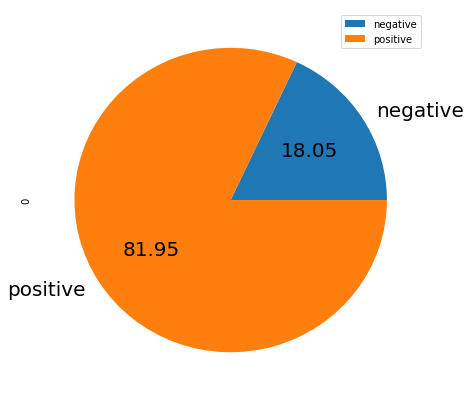

In [53]:
# izveido vizualizaaciju. Shoreiz piemeerotaakais shkjiet Pie veida grafiks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
#pd.__version__
#ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
#ts = ts.cumsum()
#ts.plot()

# OK: d = {'one' : np.random.rand(10),
#     'two' : np.random.rand(10)}
# dataf = pd.DataFrame(d)
# dataf.plot(style=['o','rx'])

# OK: d = {'positive' : 109,
#     'negative' : 24}

#dataf = pd.DataFrame(d, index=[1], columns=['y'])
#dataf.plot(kind='pie', figsize=(6, 6))

#df = pd.DataFrame({'A': a, 'B': b}, index=[0])

#DataFrame = df6
#DataFrame.plot(kind='pie', figsize=(6, 6))
#df6.plot.pie(figsize=(4,4))
#OK: dataf = pd.DataFrame({109,24}, columns=['positive', 'negative'])
#dataf.plot.bar();

dataf = pd.DataFrame({'positive':[109],
                   'negative':[24]}, index=[0])
print (dataf)
print ""
print "Twiitu sentiments par Big Data tematiku sadalaas:"
dataf.T.plot.pie(subplots=True, autopct='%.2f', fontsize=20, figsize=(7, 7))

In [58]:
# nobeigumaa viens piemeers par analizeeto tviitu statistiku, izmantojot mllib
import pyspark.mllib.stat as st
import numpy as np
numeric_cols = ['reply_count', 'retweet_count', 'favorite_count','quote_count']

#['favourites_count','followers_count','friends_count','listed_count','statuses_count','reply_count',
#                'retweet_count']

#AnalysisException: u"cannot resolve 'followers_count' given input columns:
#[extended_entities, extended_tweet, in_reply_to_screen_name, in_reply_to_user_id_str,
#timestamp_ms, display_text_range, id, created_at, truncated, reply_count, 
#contributors, possibly_sensitive, source, retweet_count, text, lang, filter_level, 
#favorite_count, id_str, place, in_reply_to_status_id_str, coordinates, quoted_status, 
# quoted_status_id_str, quote_count, retweeted_status, in_reply_to_status_id, in_reply_to_user_id, 
# favorited, is_quote_status, entities, geo, user, retweeted, quoted_status_id];"

numeric_rdd = df\
                       .select(numeric_cols)\
                       .rdd \
                       .map(lambda row: [e for e in row])

mllib_stats = st.Statistics.colStats(numeric_rdd)

for col, m, v in zip(numeric_cols, 
                     mllib_stats.mean(), 
                     mllib_stats.variance()):
    print('{0}: \t{1:.2f} \t {2:.2f}'.format(col, m, np.sqrt(v)))

reply_count: 	0.00 	 0.00
retweet_count: 	0.00 	 0.00
favorite_count: 	0.00 	 0.00
quote_count: 	0.00 	 0.00
